# Models

## Imports

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
# Operations on the GPU if available
if torch.cuda.is_available():
    print("The code is running on GPU.")
else:
    print("The code is running on CPU.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code is running on CPU.


## Functions

In [3]:
class Dataset(data.Dataset):
    """Creates a Dataset depending on the given matrices.
    
    Attributes:
        inputs(np.ndarray): Sliced matrix of inputs.
        p_type(np.ndarray): Sliced matrix of point type (from inputs).
        targets(np.ndarray): Sliced matrix of targets.
        n_u(int): Number of data points.
        n_f(int): Number of collocation points.
    
    Returns:
        X(np.ndarray): Input observation at idx.
        y(np.ndarray): Target observation at idx.
        p_type(np.ndarray): Point type at idx
    """
    def __init__(self, X_u, X_f, y, data_params, collocation=True, train=True, split=0.8):
        """Inits the Dataset, depends on collocation flag.
        
        Args:
        inputs(np.ndarray): Matrix of inputs.
        targets(np.ndarray): Matrix of targets.
        data_params(Dict): Includes the parameters of the dataset.
        collocation(bool): Indicates if the matrices should be sliced _
            to only include data points or also collocation points.
        """
        
        # Unpack parameters
        self.n_u = data_params['n_data']
        self.n_f = data_params['n_collocation']
        self.seed = data_params['seed']
        
        X_train, X_test, y_train, y_test = train_test_split(X_u, y,
                                                            train_size=split,
                                                            random_state=self.seed)
        
        idx = np.random.choice(X_train.shape[0], self.n_u, replace=False)
        X_u_train = X_train[idx, 0:2]
        p_train = X_train[idx, -1].reshape((-1,1))
        y_train = y_train[idx, :]
        
        if collocation:
            X_train = np.vstack((X_u_train, X_f[:, 0:2]))
            p_train = np.vstack((p_train, X_f[:, -1].reshape((-1,1))))
            y_train = np.vstack((y_train, np.zeros((self.n_f, 1))))
        else:
            X_train = X_u_train
        
        if train:
            self.inputs = X_train
            self.p_type = p_train
            self.targets = y_train
        else:
            self.inputs = X_test[:, 0:2]
            self.p_type = X_test[:, -1].reshape((-1,1))
            self.targets = y_test

    def __len__(self):
        """Returns the size of the dataset."""
        return len(self.targets)

    def __getitem__(self, idx):
        """Retrieve inputs and targets at the given index."""
        X = torch.Tensor(self.inputs[idx])
        p_type = torch.Tensor(self.p_type[idx])
        y = torch.Tensor(self.targets[idx])

        return X, p_type, y

In [4]:
class NN(nn.Module):
    """Feed-Forward Neural Network (NN).

    Attributes:
        layers(list): Architecture of the NN.
        act_name(str): Activation function to use after each layer.
        depth(int): Maximum depth of the NN.
        nn(nn.Sequential): Sequential container of the NN.
    """
    
    def __init__(self, nn_params):
        """Inits the NN architecture with given parameters."""
        super().__init__()
        
        # Unpack parameters
        self.layers = nn_params['layers']
        self.act_name = nn_params['act_name']
        self.loss_name = nn_params['loss_name']
        
        # Define parameters
        self.depth = len(layers) - 1
        
        # Create architecture
        self.nn = nn.Sequential()
        
        # Add layers until output layer
        for n in range(self.depth - 1):
            self.nn.add_module(f"layer_{n}", nn.Linear(layers[n], layers[n + 1]))
            self.nn.add_module(f"act_{n}", self.get_activation(self.act_name))
        
        # Output layer (excluding activation)
        self.nn.add_module(f"layer_{n + 1}", nn.Linear(layers[n + 1], layers[n + 2]))
        
        self.loss_fun = self.get_loss(self.loss_name)
        
        # Weight initialization (already Kaiming uniform)
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.xavier_normal_(m.weight)
#                 nn.init.constant_(m.bias, 0)

    def forward(self, x):
        """Feed-forward the inputs through the network."""
        return self.nn(x)
    
    def get_activation(self, name):
        """Matches the activation function name with the actual Pytorch function.

        Args:
            name(str): Name of the activation function.

        Returns:
            act(fun): Pytorch activation function.
        """

        activations = {'tanh': nn.Tanh(),
                       'relu': nn.ReLU(inplace=True),
                       'leakyrelu': nn.LeakyReLU(inplace=True),
                       'sigmoid': nn.Sigmoid()
                      }

        if name.lower() in activations:
            return activations[name.lower()]
        else: 
            raise ValueError(f'Activation function "{name}" not implemented, available activations are {list(activations.keys())}.')
        
    def get_loss(self, name):
        """Matches the loss function name with the actual Pytorch function.

        Args:
            name(str): Name of the loss function.

        Returns:
            loss(fun): Pytorch losss function.
        """

        loss_funs = {'MSE': nn.MSELoss(),
                     'MAE': nn.L1Loss(),
                    }

        if name in loss_funs:
            return loss_funs[name]
        else: 
            raise ValueError(f'Loss function "{name}" not implemented, available loss functions are {list(loss_funs.keys())}.')

In [5]:
class PINN(NN):
    """Physics-Informed Neural Network (NN).

    Attributes:
        layers(list): Architecture of the NN.
        act_name(str): Activation function to use after each layer.
        depth(int): Maximum depth of the NN.
        nn(nn.Sequential): Sequential container of the NN.
    """
    def __init__(self, nn_params, data_params):
        super().__init__(nn_params)
        
        # Unpack equation parameters
        self.m = torch.Tensor([data_params['inertia']])
        self.d = torch.Tensor([data_params['damping']])
        self.B = torch.Tensor([data_params['susceptance']])

    def forward(self, x):
        
        x.requires_grad_(True)
        
        # Forward pass
        u = self.nn(x)
        
        # First derivative
        dudx = self.gradients(u, x)[0]
        dudt = dudx[:, 1]
        
        # Second derivative
        dudxx = self.gradients(dudx, x)[0]
        dudtt = dudxx[:, 1]
        
        #u.detach_()

        # Physics term
        f = self.m * dudtt + self.d * dudt + self.B * torch.sin(u) - x[:, 0]
        #print(dudx)
        #print(dudt)
        #print(dudxx)
        #print(dudtt)
        return u, f
    
    def loss(self, u, y, p_type, f, w1=1, w2=1):
        
        # Angle loss
        #print("u:", u)
        u_filtered = u * p_type
        #print("u_filtered:",u_filtered)
        MSE_u = self.loss_fun(u_filtered, y)
        #print("MSE_u:", MSE_u)
        
        # Physics loss
        MSE_f = torch.mean(f**2)
        #print("MSE_f:", MSE_f)
        
        # Total loss
        MSE = w1*MSE_u + w2*MSE_f
        
        return MSE_u, MSE_f, MSE

    def gradients(self, outputs, inputs):
        return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)

In [6]:
def train_NN(model, train_loader, test_loader, nn_params, data_params):
    
    optim = nn_params['optim']
    
    # Initialize the optimizer
    if optim == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    elif optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Output dictionary
    out_dict = {'train_loss': [],
                'test_loss': []
               }
    
    train_loss = []
    
    for epoch in tqdm(range(n_epochs), unit='epoch'):
        
        # Activate train mode
        model.train()
        
        for (X_train, p_type, Y_train) in train_loader:
            
            X_train, p_type, Y_train = X_train.to(device), p_type.to(device), Y_train.to(device)
            
            # Zero the gradients computed for each weight
            optimizer.zero_grad()
            
            # Forward pass
            Y_hat = model(X_train)

            # Compute the loss
            loss = model.loss(Y_hat, Y_train)

            # Backward pass through the network
            loss.backward()

            # Update the weights
            optimizer.step()

            # Save train loss
            train_loss.append(loss.data.numpy())

        # Activate evaluation mode
        model.eval()
        
        test_loss = []
        
        for (X_test, p_type, Y_test) in test_loader:
            
            X_test, p_type, Y_test = X_test.to(device), p_type.to(device), Y_test.to(device)
            
            with torch.no_grad():
                
                Y_hat = model(X_test)
                
            test_loss.append(model.loss(Y_hat, Y_test).cpu().item())
        
        # Pack epoch losses
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        
    return out_dict

In [30]:
def train_PINN(model, train_loader, test_loader, nn_params, data_params):
    
    optim = nn_params['optim']
    
    # Initialize the optimizer
    if optim == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    elif optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
    n_data = data_params['n_data']
    n_collocation = data_params['n_collocation']
    
    # Output dictionary
    out_dict = {'train_loss': [],
                'test_loss': [],
                'MSE_u': [],
                'MSE_f': []
               }
    
    train_loss = []
    loss_u_e = []
    loss_f_e = []
    
    for epoch in tqdm(range(n_epochs), unit='epoch'):
        
        # Activate train mode
        model.train()
        
        for (X_train, p_type, Y_train) in train_loader:
            
            X_train, p_type, Y_train = X_train.to(device), p_type.to(device), Y_train.to(device)
            
            # Zero the gradients computed for each weight
            optimizer.zero_grad()
            
            # Forward pass
            u, f = model(X_train)

            # Compute the loss
            loss_u, loss_f, loss = model.loss(u, Y_train, p_type, f, w2=n_data/(n_data+n_collocation))
            
            loss_u_e.append(loss_u.data.numpy())
            loss_f_e.append(loss_f.data.numpy())
            
            # Backward pass through the network
            loss.backward()

            # Update the weights
            optimizer.step()

            # Save train loss
            train_loss.append(loss.data.numpy())

        # Activate evaluation mode
        model.eval()
        
        test_loss_e = []
        
        for (X_test, p_type, Y_test) in test_loader:
            
            X_test, p_type, Y_test = X_test.to(device), p_type.to(device), Y_test.to(device)
            
            u, f = model(X_test)
                
            test_loss_u, test_loss_f, test_loss = model.loss(u, Y_test, p_type, f)
            test_loss_e.append(test_loss.cpu().item())
        
        # Pack epoch losses
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['MSE_u'].append(np.mean(loss_u_e))
        out_dict['MSE_f'].append(np.mean(loss_f_e))
        out_dict['test_loss'].append(np.mean(test_loss_e))
        
    return out_dict

In [24]:
def plot_loss(results):
    plt.plot(results['train_loss'], label='train')
    plt.plot(results['test_loss'], label='test')
   # plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

## Parameters

In [9]:
# Data parameters
n_data = 101 # number of data points
n_collocation = 8000 # number of collocation points

m = 0.15 # angular inertia
d = 0.15 # damping coefficient
B = 0.2 # susceptance [pu]
delta_0 = 0 # initial angle [rad]
omega_0 = 0 # initial angular speed [rad/s]

p_min = 0.08 # minimum power [pu]
p_max = 0.18 # maximum power [pu]
p_span = (p_min, p_max)

t_min = 0 # [seconds]
t_max = 10 # [seconds]
t_span = (t_min, t_max)

seed = 1

data_params = {'n_data': n_data,
               'n_collocation': n_collocation,
               'inertia': m,
               'damping': d,
               'susceptance': B,
               'delta_0': delta_0,
               'omega_0': omega_0,
               'p_span': p_span,
               't_span': t_span,
               'seed': seed
              }

In [37]:
# NN parameters
lr = 0.001
n_epochs = 10000
batch_size = 500
optim = 'Adam' # SGD, LFBGS
loss = 'MSE' # MAE
activation = 'tanh'
layers = [2, 20, 20, 20, 1] # NN architecture

nn_params = {'learning_rate': lr,
             'n_epochs': n_epochs,
             'optim': optim,
             'loss_name': loss,
             'act_name': activation,
             'layers': layers
            }

## Data

In [11]:
with np.load('../data/data.npz') as data_npz:
    X_u = data_npz['X_u']
    X_f = data_npz['X_f']
    y_delta = data_npz['y_delta']
    y_omega = data_npz['y_omega']

In [12]:
print(f"Input shape: {X_u.shape}\n"
      f"Input shape: {X_f.shape}\n"
      f"Output shape: {y_delta.shape}\n"
      f"Output shape: {y_omega.shape}")

Input shape: (10201, 3)
Input shape: (8000, 3)
Output shape: (10201, 1)
Output shape: (10201, 1)


In [13]:
# Create datasets
train_short = Dataset(X_u, X_f, y_delta, data_params, collocation=False)
train_long = Dataset(X_u, X_f, y_delta, data_params)
test = Dataset(X_u, X_f, y_delta, data_params, train=False)

# Create train and test loaders
train_loader_short = data.DataLoader(train_short, batch_size=batch_size, shuffle=True)
train_loader_long = data.DataLoader(train_long, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test, batch_size=batch_size, shuffle=False) # num_workers=1

In [14]:
train_short.inputs.shape

(101, 2)

In [15]:
train_long.inputs.shape

(8101, 2)

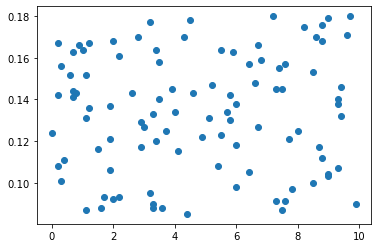

In [16]:
plt.scatter(train_short.inputs[:,1], train_short.inputs[:,0])

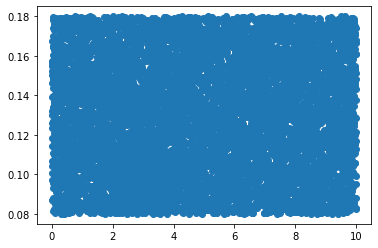

In [17]:
plt.scatter(train_long.inputs[:,1], train_long.inputs[:,0])

## NN

In [18]:
# Initialize model
model_NN = NN(nn_params)

# To GPU or CPU
model_NN.to(device)

NN(
  (nn): Sequential(
    (layer_0): Linear(in_features=2, out_features=20, bias=True)
    (act_0): Tanh()
    (layer_1): Linear(in_features=20, out_features=20, bias=True)
    (act_1): Tanh()
    (layer_2): Linear(in_features=20, out_features=20, bias=True)
    (act_2): Tanh()
    (layer_3): Linear(in_features=20, out_features=1, bias=True)
  )
  (loss_fun): MSELoss()
)

In [65]:
# Train
results_NNshort = train_NN(model_NN, train_loader_short, test_loader, nn_params, data_params)

100%|██████████| 100/100 [00:36<00:00,  2.71epoch/s]


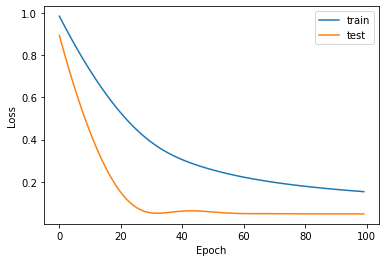

In [67]:
plot_loss(results_NNshort)

In [68]:
results_NNshort['test_loss'][-1]

0.047085853737025035

In [19]:
def plot_prediction(idx, model):
    idx=20
    preds = []
    for x in X_u[idx*n_data:idx*n_data+n_data, 0:2]:
        x = torch.Tensor(x)
        preds.append(model.nn.forward(x).item())

    plt.plot(X_u[idx*n_data:idx*n_data+n_data, 1], y_delta[idx*n_data:idx*n_data+n_data], label="exact")
    plt.plot(X_u[idx*n_data:idx*n_data+n_data, 1], preds, label="prediction")
    plt.xlabel("Time [s]")
    plt.ylabel("δ [rad]")
    plt.legend()

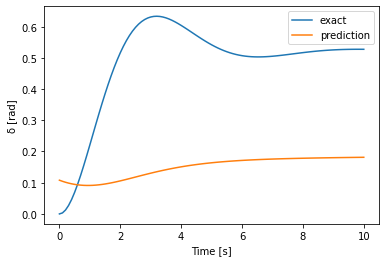

In [20]:
plot_prediction(10, model_NN)

## PINN

In [38]:
# Initialize model
model_PINN = PINN(nn_params, data_params)

# To GPU or CPU
model_PINN.to(device)

PINN(
  (nn): Sequential(
    (layer_0): Linear(in_features=2, out_features=20, bias=True)
    (act_0): Tanh()
    (layer_1): Linear(in_features=20, out_features=20, bias=True)
    (act_1): Tanh()
    (layer_2): Linear(in_features=20, out_features=20, bias=True)
    (act_2): Tanh()
    (layer_3): Linear(in_features=20, out_features=1, bias=True)
  )
  (loss_fun): MSELoss()
)

In [39]:
results_PINNlong = train_PINN(model_PINN, train_loader_long, test_loader, nn_params, data_params)

  0%|          | 10/10000 [00:07<1:59:10,  1.40epoch/s]


KeyboardInterrupt: 

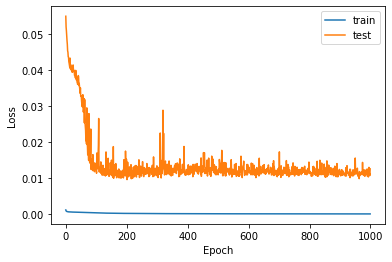

In [33]:
plot_loss(results_PINNlong)

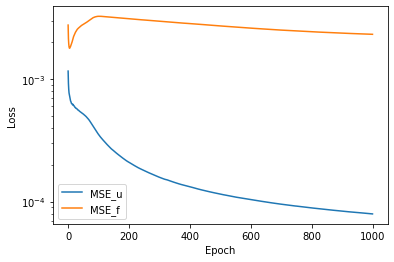

In [34]:
plt.plot(results_PINNlong['MSE_u'], label='MSE_u')
plt.plot(results_PINNlong['MSE_f'], label='MSE_f')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [35]:
results_PINNlong['test_loss'][-1]

0.012618918158113956

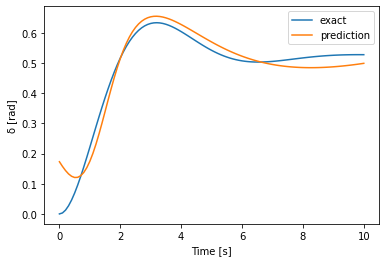

In [36]:
plot_prediction(10, model_PINN)

## BPINN